In [25]:
# tools and file location
from util import METADATA

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import pickle
import pandas as pd
import numpy as np
import glob
import pyreadstat
import pandas as pd
from scipy.stats import binom

import mne
from mne.preprocessing import Xdawn

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

import warnings
import pingouin as pg
warnings.filterwarnings("ignore")
cm = 1/2.54
results_folder = '/home/christian/Schreibtisch/lifespan/results/'
file_agepred_ytrue = results_folder + 'age_group_y_trues.pkl'
file_agepred_ypred_overtime =  results_folder + 'age_group_y_trues_overtime.pkl'
file_agepred_ytrue_overtime = results_folder + 'age_group_y_preds_overtime.pkl'
file_agepred_ypred =  results_folder + 'age_group_y_preds.pkl'
file_stimpred = results_folder + 'xdawn_runs/task_classification_results.pkl'
file_stimpred_perm = results_folder + 'xdawn_runs/taskpred_overtime_indiv_permutation_results.pkl'
file_epochs=  results_folder + 'preprocessed_epochs.pkl'


## Group Characteristics

In [26]:
with open(file_epochs,'rb') as f:
    epochs = pickle.load(f)

stat_df = METADATA[METADATA.eegusedNEW == 1]

# count number of epochs:
epochs_all = []
part = []
epoch_len_ic = []
epoch_len_c = []
for data in epochs: 
    if data[0] in stat_df.index and data[1] != None:
        epochs_all.append(data[1])
        part.append(data[0])
        epoch_len_ic.append(len(data[1]['IC_correct']))
        epoch_len_c.append(len(data[1]['C_correct']))
epoch_len = pd.DataFrame(np.transpose([epoch_len_c, epoch_len_ic]), columns=['#epochs_ic','#epochs_c'], index = part)
stat_df = epoch_len.join(stat_df)
stat_df.drop('eegusedNEW', inplace=True, axis=1)

# calculate and summarize stats
n = stat_df.groupby(['GRUPPE']).count()['#epochs_ic'].rename('N')
count_geschl = stat_df.groupby(['GRUPPE','Geschlecht']).describe()[('#epochs_ic','count')].reset_index()
female = count_geschl[count_geschl['Geschlecht'] == 1][[('GRUPPE',''),('#epochs_ic','count')]]
female = female.set_index(('GRUPPE',''))
female.columns = ['N_female']
epochs_sum = stat_df.groupby(['GRUPPE'])['#epochs_ic','#epochs_c'].sum()
epochs_sum.columns = epochs_sum.columns + '_N'
epochs_mean = stat_df.groupby(['GRUPPE'])['#epochs_ic','#epochs_c'].mean()
epochs_mean.columns = epochs_mean.columns + '_mean'
epochs_std = stat_df.groupby(['GRUPPE'])['#epochs_ic','#epochs_c'].std()
epochs_std.columns = epochs_std.columns + '_std'
epochs_min = stat_df.groupby(['GRUPPE'])['#epochs_ic','#epochs_c'].min()
epochs_min.columns = epochs_min.columns + '_min'
epochs_max = stat_df.groupby(['GRUPPE'])['#epochs_ic','#epochs_c'].max()
epochs_max.columns = epochs_max.columns + '_max'
alter_stats = stat_df.groupby(['GRUPPE'])['Alter'].describe()[['mean','std']]
alter_stats.columns = ['age_mean', 'age_sd']
summary = pd.concat([n,female,alter_stats,epochs_sum,epochs_mean,epochs_std,epochs_min,epochs_max], axis = 1)
summary.to_csv(results_folder + 'Groups_summary.csv') 
summary

,N,N_female,age_mean,age_sd,#epochs_ic_N,#epochs_c_N,#epochs_ic_mean,#epochs_c_mean,#epochs_ic_std,#epochs_c_std,#epochs_ic_min,#epochs_c_min,#epochs_ic_max,#epochs_c_max
1.0,46,23.0,9.321739,0.647358,3262,3026,70.913043,65.782609,15.296806,13.274726,36,38,98,94
2.0,39,34.0,22.846154,2.497772,2554,2476,65.487179,63.487179,24.314682,22.585361,40,36,109,109
3.0,21,12.0,42.619048,3.612149,2038,1951,97.047619,92.904762,10.331874,8.389903,79,75,125,106
4.0,25,14.0,59.040000,2.388863,2378,2372,95.120000,94.880000,10.654889,9.010734,71,80,109,113
5.0,40,36.0,71.925000,3.041487,2355,2263,58.875000,56.575000,19.733075,14.420227,40,41,111,92
6.0,38,30.0,78.142857,1.942449,2632,2506,69.263158,65.947368,21.073468,21.601986,39,36,105,101


### Results Group Classifiaction

In [27]:
# model on whole data
with open(file_agepred_ytrue,'rb') as f:
    y_trues = pickle.load(f)

with open(file_agepred_ypred,'rb') as f:
    y_preds = pickle.load(f) 

y_trues = np.concatenate(y_trues)
y_preds = np.concatenate(y_preds)

target_names = ['children','young','early-ma','late-ma','old <75', 'old >75']
report = classification_report(y_trues, y_preds, target_names = target_names, output_dict=True)
print(classification_report(y_trues, y_preds, target_names = target_names))
n = report['macro avg']['support']
c = len(target_names)
sign_thresh = binom.ppf(.95,n,1/c)/n
print(f"chance level: {sign_thresh:.2f}")

              precision    recall  f1-score   support

    children       0.86      0.99      0.92      6288
       young       0.58      0.53      0.55      5030
    early-ma       0.41      0.50      0.45      3989
     late-ma       0.43      0.38      0.40      4750
     old <75       0.42      0.40      0.41      4618
     old >75       0.42      0.36      0.39      5138

    accuracy                           0.55     29813
   macro avg       0.52      0.53      0.52     29813
weighted avg       0.54      0.55      0.54     29813

chance level: 0.17


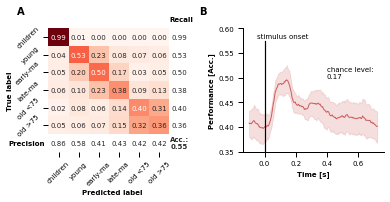

In [28]:
sns.set_context('paper')

#model over time
with open(file_agepred_ytrue_overtime,'rb') as f:
    y_trues_w = pickle.load(f)

with open(file_agepred_ypred_overtime,'rb') as f:
    y_preds_w = pickle.load(f)

scores = []
for y_true_ws, y_pred_ws in zip(y_trues_w, y_preds_w):
    scores_ws = []
    for y_true_w, y_pred_w in zip(y_true_ws, y_pred_ws):
        scores_ws.append(accuracy_score(y_true_w, y_pred_w))
    scores.append(scores_ws)
scores = pd.DataFrame(scores)
scores.columns = ['acc' + str(col) for col in scores.columns]
scores['iteration'] = scores.index
scores_long = pd.wide_to_long(scores, stubnames='acc', i=['iteration'], j='t').reset_index()
scores_long['t'] = scores_long.t/256 - .1

# overall performance
confmat = confusion_matrix(y_trues, y_preds)
confmat = pd.DataFrame(confmat, index = target_names, columns = target_names)
confmat['Recall'] = -999
confmat.loc['Precision'] = -999
confmat_norm = confusion_matrix(y_trues, y_preds, normalize='true')
confmat_norm = pd.DataFrame(confmat_norm, index = target_names, columns = target_names)
confmat_norm['Recall'] = -999
confmat_norm.loc['Precision'] = -999
absolute = np.asarray(confmat.iloc[:-1,:-1])
normed = confusion_matrix(y_trues, y_preds, normalize='true')*100
precision = [f"{report[g]['precision']:.2f}" for g in target_names]
precision.append(f"Acc.:\n{report['accuracy']:.2f}")
recall = [f"{report[g]['recall']:.2f}" for g in target_names]

# Figure 
# create text for annotation 
fig, ax = plt.subplots(1,2,figsize=(14*cm,7.5*cm))
sns.color_palette('pastel')
formatted = (np.asarray([f"{absi}\n{normi:.1f}%" for absi, normi in zip(absolute.flatten(), normed.flatten())])).reshape(6, 6)
formatted = np.column_stack((formatted,recall))
formatted = np.append(formatted, [precision], axis=0)
mask = confmat_norm.to_numpy(dtype=float) < -1
_ = sns.heatmap(confmat_norm, annot=True, fmt=".2f", cbar = False, ax = ax[0],annot_kws={'fontsize': 7}, cmap= "Reds", mask = mask, vmax = 1)
mask = confmat_norm.to_numpy(dtype=float) > -1
mask[6,6] = True
_ = sns.heatmap(confmat_norm, annot=formatted, fmt="", cbar = False, ax = ax[0],annot_kws={'fontsize': 7}, cmap= "Greys", mask = mask)
mask[:,:] = True
mask[6,6] = False

# subplot 1
_ = sns.heatmap(confmat_norm, annot=formatted, fmt="", cbar = False, ax = ax[0],annot_kws={'fontsize': 7, 'fontweight':'bold'}, cmap= "Greys", mask=mask)
_.set_ylabel('True label',fontsize=7, fontweight='bold')
_.set_xlabel('Predicted label',fontsize=7,fontweight='bold')
_.set_xticks([0.5, 1.5, 2.5, 3.5, 4.5, 5.5])
_.set_xticklabels(target_names,fontsize=7, rotation=45)
_.set_yticks([0.5, 1.5, 2.5, 3.5, 4.5, 5.5])
_.set_yticklabels(target_names ,fontsize=7, rotation=45)
_.text(6,-.4,'Recall',fontsize=7, fontweight='bold')
_.text(-2,6.6,'Precision',fontsize=7, fontweight='bold')
_.yaxis.set_label_coords(-.25,.5)
_.xaxis.set_label_coords(.45,-.3)

# subplot 2
_ = sns.lineplot(data = scores_long, y = 'acc',  x = 't', lw = 1, ci = 95, color='indianred', ax=ax[1])
_.axvline(0, ymax=.9, linestyle='-', color='k', label = 'stimulus onset')
_.set_ylim([0.35,.6])
_.set_ylabel('Performance [Acc.]', fontsize=7, fontweight='bold')
_.set_xlabel('Time [s]', fontsize=7, fontweight='bold')
_.tick_params(labelsize=7)
_.text(-.05,.58,'stimulus onset', fontsize=7)
_.text(.4,.5,f'chance level:\n0.17', fontsize=7)

# additional
fig.text(.51,.95,'B', fontsize=10, fontweight='bold')
fig.text(0.05,.95,'A', fontsize=10, fontweight='bold')
sns.despine(ax=ax[1])
fig.tight_layout(w_pad=1.5)
fig.savefig(results_folder + 'group_classification.svg')


In [29]:
# spatial filter on whole data (for visualization only!)
# mne.set_log_level(False)
# epochs_all = [data[1] for data in epochs if data[1] != None]
# epochs_all = mne.concatenate_epochs(epochs_all)
# event_id = epochs_all.event_id
# n_filter = 5
# xd = Xdawn(n_components=n_filter).fit(epochs_all)
# epochs_denoised = xd.apply(epochs_all)

In [30]:

# info = mne.create_info(epochs_all.ch_names, 1, epochs_all.get_channel_types())
# info.set_montage(epochs_all.get_montage())
# fig, axes = plt.subplots(nrows=len(event_id), ncols=n_filter,
#                          figsize=(n_filter, len(event_id) * 2))
# for ii, cur_class in enumerate(sorted(epochs_all.event_id)):
#     cur_patterns = xd.patterns_[cur_class]
#     pattern_evoked = mne.EvokedArray(cur_patterns[:5].T, info, tmin=0)
#     pattern_evoked.plot_topomap(
#         times=np.arange(5),
#         time_format='Comp. %d' if ii == 0 else '', colorbar=False,
#         show_names=False, axes=axes[ii], show=False)
#     axes[ii, 0].set(ylabel=cur_class)

#fig.tight_layout(h_pad=1.0, w_pad=1.0, pad=0.1)
# n_filter = 5
# cm = 1/2.54
# picks = ['O2','Pz','Fz']
# fig, ax = plt.subplots(3,6, figsize = (9,5))
# for j,g in enumerate(sorted(stat_df.dropna().GRUPPE.unique())):
#     part_group = stat_df[stat_df.GRUPPE == g].index.values
#     epochs_group = [data[1] for data in epochs if data[1] != None and data[0] in part_group]
#     epochs_group = mne.concatenate_epochs(epochs_group)
#     xd = Xdawn(n_components=n_filter).fit(epochs_group)
#     e = xd.apply(epochs_group)
#     e['IC_correct'] = e['IC_correct'].apply_baseline(baseline=(-.1,0))
#     e['C_correct'] = e['C_correct'].apply_baseline(baseline=(-.1,0))
#     ic = e['IC_correct'].average()
#     c = e['C_correct'].average()
#     times = ic.times
#     for i,pick in enumerate(picks):
#         this_ic = ic.get_data(picks=pick)*1e6 #scale to microvolt
#         this_c = c.get_data(picks=pick)*1e6
#         if pick == ['O1','O2']:
#             this_ic = np.median(this_ic,axis=0)
#             this_c = np.median(this_c,axis=0)
#         else:
#             this_ic = this_ic[0]
#             this_c = this_c[0]
#         ax[i,j].plot(times, this_ic, color = 'darkred', linestyle = '--')
#         ax[i,j].plot(times, this_c, color = 'grey')
#         ax[i,j].axhline(0, color = 'k')
#         ax[i,j].axvline(0  , color = 'k')
#         ax[i,j].spines['right'].set_visible(False)
#         ax[i,j].spines['top'].set_visible(False)

# for i in range(6):
#     ax[0,i].set_ylim([-12,20])
#     ax[1,i].set_ylim([-8,17])
#     ax[2,i].set_ylim([-8,17])
#     if i > 0: 
#         ax[0,i].get_yaxis().set_ticklabels([])
#         ax[1,i].get_yaxis().set_ticklabels([])
#         ax[2,i].get_yaxis().set_ticklabels([])

# ax[0,0].set_ylabel('Amplitude [µV]')
# ax[0,0].set_xlabel('Time [s]')
# ax[0,0].text(250,19,'children')
# ax[0,1].text(250,19,'young')
# ax[0,2].text(250,19,'early-ma')
# ax[0,3].text(250,19,'late-ma')
# ax[0,4].text(250,19,'old <75')
# ax[0,5].text(250,19,'old >75')
# ax[0,0].text(-150,21,'O2')
# ax[1,0].text(-150,18,'Pz')
# ax[2,0].text(-150,18,'Fz')
# plt.tight_layout()

### Results Task Classification

In [31]:
def read_scores(file_name, out = None, srate = 256, offset = .1, iteration = 10):
    with open(file_name,'rb') as f:
        preds = pickle.load(f)
        scores = []
        for k in preds:
            try:
                tmp = pd.DataFrame(np.asarray(preds[k]))
                tmp['part'] = k.lower()
                if iteration > 1:
                    tmp['iteration'] = np.arange(iteration) #10 for 10fold
                scores.append(tmp)
                scores_df = pd.concat(scores)
                cols = [i if i in ['part','iteration']  else 'acc' + str(i) for i in scores_df.columns]
                scores_df.columns = cols
            except:
                continue

    # option for plotting
    if out == 'long':
        scores_df = make_scores_long(scores_df,srate,offset)
    else: 
        scores_df.set_index('part', inplace = True)

    return scores_df

def make_scores_long(scores_df,srate,offset):
    scores_long = pd.wide_to_long(scores_df, stubnames='acc', i=['part','iteration'], j='t').reset_index()
    scores_long.t = scores_long.t/srate - offset
    scores_long = scores_long.groupby(['part','t']).mean().reset_index()
    scores_long.set_index('part', inplace = True)
    return scores_long

scores_stimpred = read_scores(file_stimpred, out='long')

## Merge scores from stimuls prediction with stats

# stats
stat_df = METADATA[['GRUPPE','Alter']]

# classification scores
scores_stimpred = scores_stimpred.join(stat_df)
scores_stimpred.GRUPPE.replace([1,2,3,4,5,6],['children','young','early-ma','late-ma', 'old <75', 'old >75'], inplace = True)
scores_stimpred.reset_index(inplace=True)

# permutation scores
scores_stimpred_perm = read_scores(file_stimpred_perm,iteration = 1)

# extract maximum and timepoint of max
scores_stimpred_max = scores_stimpred.groupby(['part','GRUPPE','Alter'])['acc'].max()
scores_stimpred_max = pd.DataFrame(scores_stimpred_max).reset_index()
scores_stimpred_max.set_index('part', inplace = True)
scores_stimpred_t = scores_stimpred.set_index('t')
scores_stimpred_t = scores_stimpred_t.groupby(['part','GRUPPE','Alter'])['acc'].idxmax()
scores_stimpred_t.name = 't'
scores_stimpred_t = pd.DataFrame(scores_stimpred_t).reset_index()
scores_stimpred_t.set_index('part', inplace = True)
scores_stimpred_max = scores_stimpred_max.join(scores_stimpred_t.t)

# calculate sign. threshold
thresh_p = np.percentile(scores_stimpred_perm.acc0, 95)
thresh_mean = np.mean(scores_stimpred_perm.acc0)
order = ['children','young','early-ma','late-ma','old <75','old >75']
print(f'Significance Threshold: {thresh_p:.2f}')
print(f'Percentage of participants above chance: {len(scores_stimpred_max[scores_stimpred_max.acc > thresh_p]) / len(scores_stimpred_max) * 100:.2f} %')

Significance Threshold: 0.61
Percentage of participants above chance: 95.75 %


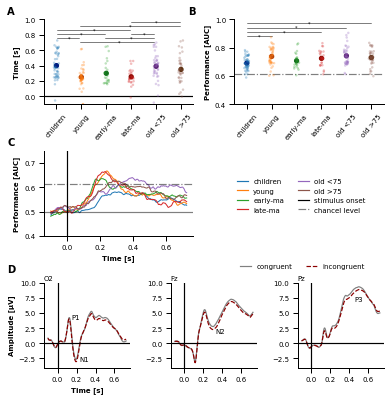

In [32]:
# spatial filter on whole data (for visualization only!)
mne.set_log_level(False)
n_filter = 5
times = epochs_all[0].times
n1p1_ic = []
n1p1_c = []
n2_ic = []
n2_c = []
p3_ic = []
p3_c = []

for part_epochs in epochs_all:
    xd = Xdawn(n_components=n_filter).fit(part_epochs)
    part_epochs_denoised = xd.apply(part_epochs)
    c_evoked = part_epochs_denoised['C_correct'].apply_baseline(baseline=(-.1,0)).average()
    ic_evoked = part_epochs_denoised['IC_correct'].apply_baseline(baseline=(-.1,0)).average()
    n1p1_c.append(c_evoked.get_data(picks='O2')*1e6)
    n2_c.append(c_evoked.get_data(picks='Fz')*1e6)
    p3_c.append(c_evoked.get_data(picks='Pz')*1e6)
    n1p1_ic.append(ic_evoked.get_data(picks='O2')*1e6)
    n2_ic.append(ic_evoked.get_data(picks='Fz')*1e6)
    p3_ic.append(ic_evoked.get_data(picks='Pz')*1e6)

# plot everything
fig = plt.figure(figsize=(14*cm,14*cm))
gs = GridSpec(3, 6, figure=fig)

# latency of maximum decoding
ax1 = fig.add_subplot(gs[0, :3])
_ = sns.stripplot(x="GRUPPE", y="t",
             data=scores_stimpred_max, order=order, alpha = .3, ax = ax1, size=2.5)
_ = sns.pointplot(x="GRUPPE", y="t",
              data=scores_stimpred_max, markers = 6*["o"], join=False,
              ci=None, order=order, ax = ax1, palette="dark",scale=.75)
_.set_ylabel('Time [s]',fontsize=7, fontweight='bold')
_.set_xlabel('Group',fontsize=7,fontweight='bold')
_.set_ylim([-.1,1])
_.set_xlabel(None) 
_.axhline(0, linestyle='-', color='k', label = 'sign. thresh.')

fs_star = 5
# children vs XY
_.axhline(.76, xmin=.084,xmax=.235, color='k', linewidth=.5)
_.text(.45,.74,'*',fontsize=fs_star)
_.axhline(.81, xmin=.084,xmax=.41, color='k', linewidth=.5)
_.text(.95,.79,'*',fontsize=fs_star)
_.axhline(.86, xmin=.084,xmax=.576, color='k', linewidth=.5)
_.text(1.45,.84,'*',fontsize=fs_star)

# old <75 vs XY
_.axhline(.71, xmin=.24,xmax=.735, color='k', linewidth=.5)
_.text(2.45,.69,'*',fontsize=fs_star)
_.axhline(.76, xmin=.406,xmax=.735, color='k', linewidth=.5)
_.text(2.94,.74,'*',fontsize=fs_star)
_.axhline(.81, xmin=.583,xmax=.735, color='k', linewidth=.5)
_.text(3.45,.79,'*',fontsize=fs_star)

# old >75 vs XY
_.axhline(.96, xmin=.583,xmax=.912, color='k', linewidth=.5)
_.text(3.95,.94,'*',fontsize=fs_star)
_.axhline(.91, xmin=.24,xmax=.912, color='k', linewidth=.5)
_.text(2.9,.89,'*',fontsize=fs_star)

_.set_yticks([0.0, 0.2, 0.4 , 0.6, 0.8, 1.0])
_.tick_params(axis="x", rotation=50, labelsize = 7)
_.tick_params(axis="y",labelsize = 7)

# max decoding
ax2 = fig.add_subplot(gs[0, 3:6])
_ = sns.stripplot(x="GRUPPE", y="acc",
             data=scores_stimpred_max, order=order, alpha = .3, ax = ax2, size=2.5)
_ = sns.pointplot(x="GRUPPE", y="acc",
              data=scores_stimpred_max, markers = 6*["o"], join=False,
              ci=None, order=order, ax = ax2, palette="dark",scale=.75)
_.tick_params(axis="x", rotation=50, labelsize = 8)
_.set_ylabel('Performance [AUC]', fontsize=7, fontweight='bold')
_.set_xlabel('Group', fontsize=7, fontweight='bold')
_.set_ylim([0.4,1])
_.set_xlabel(None)
_.tick_params(axis="x", rotation=50, labelsize = 7)
_.tick_params(axis="y",labelsize = 7)
_.set_yticks([0.4 , 0.6, 0.8, 1.0])
_.axhline(thresh_p, linestyle='-.', color='k', alpha = 0.5, label = 'chance level')
_.axhline(.88,xmin=.084,xmax=.25, color='k', linewidth=.5)
_.text(.45,.87,'*',fontsize=fs_star)
_.axhline(.91,xmin=.084,xmax=.583, color='k', linewidth=.5)
_.text(1.45,.9,'*',fontsize=fs_star)
_.axhline(.94,xmin=.084,xmax=.75, color='k', linewidth=.5)
_.text(1.95,.93,'*',fontsize=fs_star)
_.axhline(.97,xmin=.084,xmax=.917, color='k', linewidth=.5)
_.text(2.45,.96,'*',fontsize=fs_star)


# decoding over time
ax3 = fig.add_subplot(gs[1, :3])
_ = sns.lineplot(data = scores_stimpred, y = 'acc',  x = 't', hue = 'GRUPPE', palette = 'tab10', lw = 1, ci = None,hue_order=order, ax=ax3)
_.axvline(0, linestyle='-', color='k', label = 'stimulus onset')
_.axhline(thresh_p, linestyle='-.', color='k', alpha = 0.5, label = 'chancel level')
_.axhline(0.5, linestyle='-', color='k', alpha = 0.5)
_.set_ylim([0.4,.75])
_.set_ylabel('Performance [AUC]',fontsize=7, fontweight='bold')
_.set_xlabel('Time [s]',fontsize=7, fontweight='bold')

# ERPs
ax4 = fig.add_subplot(gs[2, :2])
sns.lineplot(x=times[:-20],y=np.mean(n1p1_c,axis=0)[0,:-20],ax=ax4, color='grey')
sns.lineplot(x=times[:-20],y=np.mean(n1p1_ic,axis=0)[0,:-20],ax=ax4,color='darkred', linestyle='--')
ax4.set_ylim([-4,10])
ax4.axvline(0, linestyle='-', color='k')
ax4.axhline(0, linestyle='-', color='k')
ax4.set_ylabel('Amplitude [µV]', fontsize=7, fontweight='bold')
ax4.set_xlabel('Time [s]', fontsize=7, fontweight='bold')
ax4.set_ylim([-4,10])
ax4.set_xticks([0.0, 0.2, 0.4 , 0.6])
ax4.text(-.15,10.5,'O2', fontsize=7)
ax4.text(.225,-3,'N1', fontsize=7)
ax4.text(.15,4,'P1', fontsize=7)
ax4.tick_params(labelsize = 7)


ax5 = fig.add_subplot(gs[2, 2:4])
sns.lineplot(x=times[:-20],y=np.mean(n2_c,axis=0)[0,:-20],ax=ax5,color='grey')
sns.lineplot(x=times[:-20],y=np.mean(n2_ic,axis=0)[0,:-20],ax=ax5,color='darkred', linestyle='--')
ax5.set_ylim([-4,10])
ax5.axvline(0, linestyle='-', color='k')
ax5.axhline(0, linestyle='-', color='k')
ax5.set_xticks([0.0, 0.2, 0.4 , 0.6])
ax5.text(-.15,10.5,'Fz', fontsize=7)
ax5.text(.325,1.75,'N2', fontsize=7)
ax5.tick_params(labelsize = 7)


ax6 = fig.add_subplot(gs[2, 4:6])
sns.lineplot(x=times[:-20],y=np.mean(p3_c,axis=0)[0,:-20],ax=ax6, color='grey', label = 'congruent')
sns.lineplot(x=times[:-20],y=np.mean(p3_ic,axis=0)[0,:-20],ax=ax6,color='darkred', linestyle='--',label = 'incongruent')
ax6.set_ylim([-4,10])
ax6.axvline(0, linestyle='-', color='k')
ax6.axhline(0, linestyle='-', color='k')
ax6.set_xticks([0.0, 0.2, 0.4 , 0.6])
ax6.text(-.15,10.5,'Pz', fontsize=7)
ax6.text(.45,7,'P3', fontsize=7)
ax6.tick_params(labelsize = 7)

sns.despine(right=True)
fig.tight_layout()
_.tick_params(labelsize=7)
_.legend(bbox_to_anchor=(1.25, .75),title="", ncol=2, handlelength = 1.5, frameon=False, fontsize=7)
ax6.legend(bbox_to_anchor=(.85, 1.3),title="", handlelength = 1.5, frameon=False, fontsize=7, ncol=2)
fig.text(0.025,.98,'A', fontsize=10, fontweight='bold')
fig.text(.48,.98,'B', fontsize=10, fontweight='bold')
fig.text(0.025,.65,'C', fontsize=10, fontweight='bold')
fig.text(0.025,.33,'D', fontsize=10, fontweight='bold')
fig.savefig(results_folder + 'task_classification.svg')


### Statistical Analysis

#### Latency of the maximum decoding accuracy

In [33]:
import scipy.stats as stats
#check assumptions
for g in scores_stimpred_max['GRUPPE'].unique():
    shp_res = stats.shapiro(scores_stimpred_max[scores_stimpred_max['GRUPPE'] == g]['t'])
    print(f'{g}:{shp_res}')

children:ShapiroResult(statistic=0.9500472545623779, pvalue=0.04348523169755936)
old <75:ShapiroResult(statistic=0.9651144742965698, pvalue=0.24945828318595886)
old >75:ShapiroResult(statistic=0.9773392081260681, pvalue=0.6550202965736389)
late-ma:ShapiroResult(statistic=0.9512729048728943, pvalue=0.2677960693836212)
early-ma:ShapiroResult(statistic=0.9174438118934631, pvalue=0.0673074722290039)
young:ShapiroResult(statistic=0.9077619910240173, pvalue=0.0024784172419458628)


In [34]:
stats.kruskal(scores_stimpred_max[scores_stimpred_max['GRUPPE'] == 'children']['t'],
               scores_stimpred_max[scores_stimpred_max['GRUPPE'] == 'young']['t'],
               scores_stimpred_max[scores_stimpred_max['GRUPPE'] == 'early-ma']['t'],
               scores_stimpred_max[scores_stimpred_max['GRUPPE'] == 'late-ma']['t'],
               scores_stimpred_max[scores_stimpred_max['GRUPPE'] == 'old <75']['t'],
               scores_stimpred_max[scores_stimpred_max['GRUPPE'] == 'old >75']['t'])


KruskalResult(statistic=35.57467896080853, pvalue=1.15523936523868e-06)

In [35]:
import scikit_posthocs as sp
sp.posthoc_dunn(scores_stimpred_max, val_col='t', group_col='GRUPPE', p_adjust = 'fdr_bh')

,children,early-ma,late-ma,old <75,old >75,young
children,1.000000,0.017330,0.000723,0.938601,0.291660,0.000119
early-ma,0.017330,1.000000,0.477688,0.017132,0.218052,0.462272
late-ma,0.000723,0.477688,1.000000,0.000723,0.024108,0.991246
old <75,0.938601,0.017132,0.000723,1.000000,0.268232,0.000119
old >75,0.291660,0.218052,0.024108,0.268232,1.000000,0.013565
young,0.000119,0.462272,0.991246,0.000119,0.013565,1.000000


In [36]:
for g in scores_stimpred_max['GRUPPE'].unique():
    shp_res = stats.shapiro(scores_stimpred_max[scores_stimpred_max['GRUPPE'] == g]['acc'])
    print(f'{g}:{shp_res}')

children:ShapiroResult(statistic=0.9832135438919067, pvalue=0.7275943756103516)
old <75:ShapiroResult(statistic=0.9545913934707642, pvalue=0.10916373878717422)
old >75:ShapiroResult(statistic=0.965401828289032, pvalue=0.3135046362876892)
late-ma:ShapiroResult(statistic=0.9807582497596741, pvalue=0.8997138738632202)
early-ma:ShapiroResult(statistic=0.9536786079406738, pvalue=0.3728209137916565)
young:ShapiroResult(statistic=0.9827887415885925, pvalue=0.7683752775192261)


In [37]:
import scipy.stats as stats

stats.f_oneway(scores_stimpred_max[scores_stimpred_max['GRUPPE'] == 'children']['acc'],
               scores_stimpred_max[scores_stimpred_max['GRUPPE'] == 'young']['acc'],
               scores_stimpred_max[scores_stimpred_max['GRUPPE'] == 'early-ma']['acc'],
               scores_stimpred_max[scores_stimpred_max['GRUPPE'] == 'late-ma']['acc'],
               scores_stimpred_max[scores_stimpred_max['GRUPPE'] == 'old <75']['acc'],
               scores_stimpred_max[scores_stimpred_max['GRUPPE'] == 'old >75']['acc'])

F_onewayResult(statistic=4.804872804269212, pvalue=0.00035475346536726173)

In [38]:
import statsmodels.stats.multicomp as mc

comp = mc.MultiComparison(scores_stimpred_max['acc'], scores_stimpred_max['GRUPPE'])
tbl, a1, a2 = comp.allpairtest(stats.ttest_ind, method= "fdr_bh")

tbl

group1,group2,stat,pval,pval_corr,reject
children,early-ma,-1.2879,0.2022,0.3792,False
children,late-ma,-2.7219,0.0082,0.0307,True
children,old <75,-4.2671,0.0001,0.0007,True
children,old >75,-3.4333,0.0009,0.0047,True
children,young,-4.109,0.0001,0.0007,True
early-ma,late-ma,-1.0464,0.301,0.4515,False
early-ma,old <75,-2.1054,0.0395,0.1184,False
early-ma,old >75,-1.4742,0.146,0.3129,False
early-ma,young,-1.9458,0.0562,0.1405,False
late-ma,old <75,-1.1082,0.272,0.4515,False


In [39]:
from pathlib import Path
import glob
import pyreadstat
import pandas as pd
from scipy.stats import spearmanr
from statsmodels.stats.multitest import fdrcorrection
import pingouin as pg
stat = glob.glob('/media/christian/SEAGATE_BAC/Hard_drive/data/Lifespan/EEG_Daten_Flanker/stats/*.sav')

## Correlation behavior and task classification

              n         r          CI95%     p-val  p-val_corr
task                                                          
icongruent  212  0.128825  [-0.01, 0.26]  0.061766    0.061766
congruent   212  0.136974    [0.0, 0.27]  0.046899    0.061766


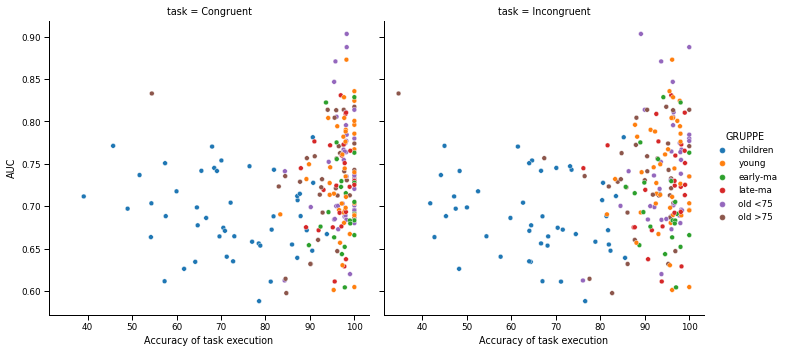

In [40]:
accuracy = glob.glob(str(Path.cwd().parent / 'results' / 'acc*.csv'))
accuracy = pd.read_csv(accuracy[0], index_col=0)
accuracy['part'] = accuracy['part'].str.lower()
accuracy = accuracy.set_index('part')
ic = accuracy[accuracy.task == 'IC']
c = accuracy[accuracy.task == 'C']
df = scores_stimpred_max.rename(columns = {'acc':'acc_max'})
c_accmax = c.join(df)
c_accmax.dropna(inplace = True)
c_accmax['task']='Congruent'
ic_accmax = ic.join(df)
ic_accmax.dropna(inplace = True)
ic_accmax['task']='Incongruent'
beh_accmax = pd.concat([c_accmax,ic_accmax])
_ =  sns.relplot(x='acc', y ='acc_max', data=beh_accmax, hue='GRUPPE', col='task', kind='scatter', hue_order=order)
_.set_ylabels('AUC')
_.set_xlabels('Accuracy of task execution')
# sns.relplot(x='acc', y ='acc_max', data=ic_accmax, hue='GRUPPE', col='GRUPPE', kind='scatter', hue_order=order)
# sns.relplot(x='acc', y ='acc_max', data=c_accmax, hue='GRUPPE', col='GRUPPE', kind='scatter', hue_order=order)

corr_ic = pg.partial_corr(x='acc', y ='acc_max', covar='Alter', data = ic_accmax)
corr_ic['task']='icongruent' 
corr_c = pg.partial_corr(x='acc', y ='acc_max', covar='Alter', data = c_accmax)
corr_c['task']='congruent' 
corr = pd.concat([corr_ic,corr_c])
corr['p-val_corr'] = fdrcorrection(corr['p-val'])[1]
corr.set_index('task', inplace = True)
print(f'{corr}')


In [41]:
# For each group seperately

for g in order: 
    print(f'Group:{spearmanr(ic_accmax[ic_accmax.GRUPPE == g].acc_max, ic_accmax[ic_accmax.GRUPPE == g].acc)}')

Group:SpearmanrResult(correlation=-0.1132730062949702, pvalue=0.44839440864608615)
Group:SpearmanrResult(correlation=-0.005841315375141049, pvalue=0.9707131400683682)
Group:SpearmanrResult(correlation=-0.16723166510767634, pvalue=0.45695970020442334)
Group:SpearmanrResult(correlation=0.1988844045253277, pvalue=0.34055006080609973)
Group:SpearmanrResult(correlation=0.23770854605907818, pvalue=0.13967765701073498)
Group:SpearmanrResult(correlation=0.028448220907478436, pvalue=0.8691812494708744)


              n         r           CI95%     p-val  p-val_corr
task                                                           
icongruent  212 -0.189267  [-0.32, -0.06]  0.005817    0.005817
congruent   212 -0.205008  [-0.33, -0.07]  0.002771    0.005542


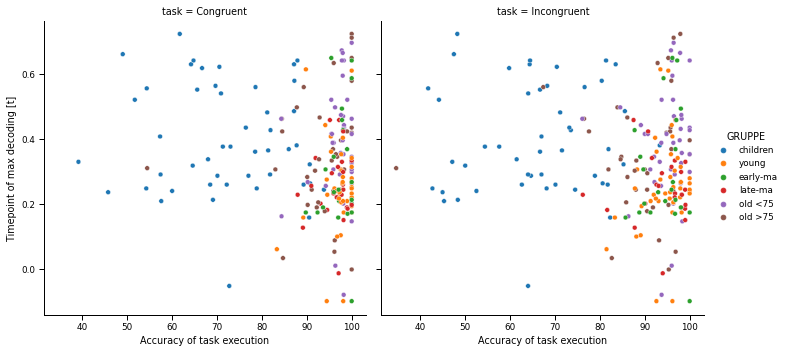

In [42]:
_ =  sns.relplot(x='acc', y ='t', data=beh_accmax, hue='GRUPPE', col='task', kind='scatter', hue_order=order)
_.set_ylabels('Timepoint of max decoding [t]')
_.set_xlabels('Accuracy of task execution')
# sns.relplot(x='acc', y ='t', data=ic_accmax, hue='GRUPPE', col='GRUPPE', kind='scatter', hue_order=order)
# sns.relplot(x='acc', y ='t', data=c_accmax, hue='GRUPPE', col='GRUPPE', kind='scatter', hue_order=order)

corr_ic = pg.partial_corr(x='acc', y ='t', covar='Alter', data = ic_accmax)
corr_ic['task']='icongruent' 
corr_c = pg.partial_corr(x='acc', y ='t', covar='Alter', data = c_accmax)
corr_c['task']='congruent' 
corr = pd.concat([corr_ic,corr_c])
corr['p-val_corr'] = fdrcorrection(corr['p-val'])[1]
corr.set_index('task', inplace = True)
print(f'{corr}')

In [43]:
for g in order: 
    print(f'{g}: {spearmanr(ic_accmax[ic_accmax.GRUPPE == g].t, ic_accmax[ic_accmax.GRUPPE == g].acc)}')

children: SpearmanrResult(correlation=0.0974579967336009, pvalue=0.5145939958203036)
young: SpearmanrResult(correlation=0.24500902475038713, pvalue=0.11784953506378414)
early-ma: SpearmanrResult(correlation=0.04128959936477592, pvalue=0.8552390196150903)
late-ma: SpearmanrResult(correlation=-0.10512132497342333, pvalue=0.6170139106765176)
old <75: SpearmanrResult(correlation=0.07591846549486844, pvalue=0.6415033355045157)
old >75: SpearmanrResult(correlation=0.07087678640401697, pvalue=0.681241329612749)


              n         r           CI95%     p-val  p-val_corr
task                                                           
icongruent  212 -0.252224  [-0.37, -0.12]  0.000214    0.000214
congruent   212 -0.277495   [-0.4, -0.15]  0.000044    0.000087


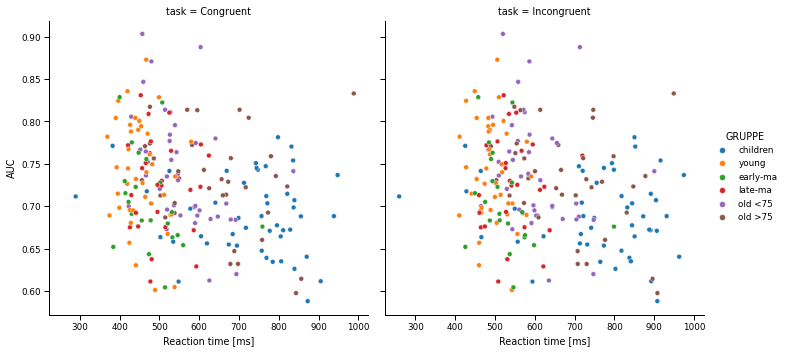

In [44]:
response_time = glob.glob(str(Path.cwd().parent / 'results' / 'rt*.csv'))
rt = pd.read_csv(response_time[0], index_col=0)
rt = rt.groupby(['part','task']).median().reset_index()
rt['part'] = rt['part'].str.lower()
rt = rt.set_index('part')
ic_rt = rt[rt.task == 'IC']
c_rt = rt[rt.task == 'C']
df = scores_stimpred_max.rename(columns = {'acc':'acc_max'})
c_rtmax = c_rt.join(df)
c_rtmax.dropna(inplace = True)
c_rtmax['task']='Congruent'
ic_rtmax = ic_rt.join(df)
ic_rtmax.dropna(inplace = True)
ic_rtmax['task']='Incongruent'
beh_rtmax = pd.concat([c_rtmax,ic_rtmax])
_ =  sns.relplot(x='rt', y ='acc_max', data=beh_rtmax, hue='GRUPPE', col='task', kind='scatter', hue_order=order)
_.set_ylabels('AUC')
_.set_xlabels('Reaction time [ms]')
# sns.relplot(x='acc', y ='acc_max', data=ic_accmax, hue='GRUPPE', col='GRUPPE', kind='scatter', hue_order=order)
# sns.relplot(x='acc', y ='acc_max', data=c_accmax, hue='GRUPPE', col='GRUPPE', kind='scatter', hue_order=order)

corr_ic = pg.partial_corr(x='rt', y ='acc_max', covar='Alter', data = ic_rtmax)
corr_ic['task']='icongruent' 
corr_c = pg.partial_corr(x='rt', y ='acc_max', covar='Alter', data = c_rtmax)
corr_c['task']='congruent' 
corr = pd.concat([corr_ic,corr_c])
corr['p-val_corr'] = fdrcorrection(corr['p-val'])[1]
corr.set_index('task', inplace = True)
print(f'{corr}')

In [45]:
p_vals = []
corr_vals = []
for g in order: 
    corr, p = spearmanr(ic_rtmax[ic_rtmax.GRUPPE == g].acc_max, ic_rtmax[ic_rtmax.GRUPPE == g].rt)#
    p_vals.append(p)
    corr_vals.append(corr)
fdrcorrection(p_vals)
corr_df=pd.DataFrame()
corr_df['Group'] = order
corr_df['r'] = corr_vals
corr_df['p-val'] = p_vals
corr_df['p-val_corr'] = fdrcorrection(p_vals)[1]
print(corr_df)

      Group         r     p-val  p-val_corr
0  children -0.081119  0.587787    0.705344
1     young -0.180146  0.253614    0.380421
2  early-ma -0.438735  0.041089    0.123268
3   late-ma  0.023846  0.909918    0.909918
4   old <75 -0.387690  0.013446    0.080674
5   old >75 -0.243243  0.152853    0.305706


              n        r         CI95%     p-val  p-val_corr
task                                                        
icongruent  212  0.19966  [0.07, 0.33]  0.003587    0.007174
congruent   212  0.16981   [0.04, 0.3]  0.013513    0.013513


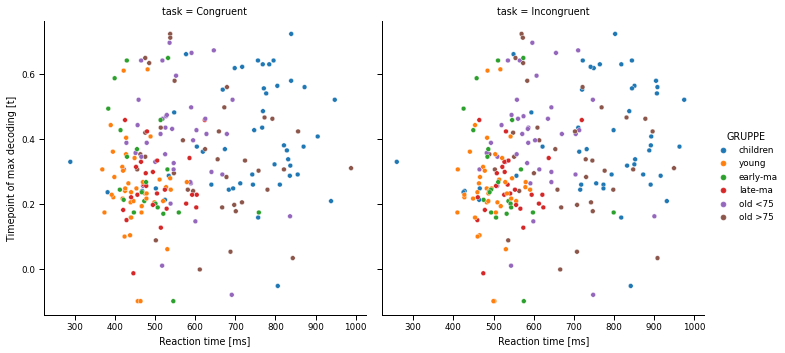

In [46]:
_ =  sns.relplot(x='rt', y ='t', data=beh_rtmax, hue='GRUPPE', col='task', kind='scatter', hue_order=order)
_.set_ylabels('Timepoint of max decoding [t]')
_.set_xlabels('Reaction time [ms]')
# sns.relplot(x='acc', y ='acc_max', data=ic_accmax, hue='GRUPPE', col='GRUPPE', kind='scatter', hue_order=order)
# sns.relplot(x='acc', y ='acc_max', data=c_accmax, hue='GRUPPE', col='GRUPPE', kind='scatter', hue_order=order)

corr_ic = pg.partial_corr(x='rt', y ='t', covar='Alter', data = ic_rtmax)
corr_ic['task']='icongruent' 
corr_c = pg.partial_corr(x='rt', y ='t', covar='Alter', data = c_rtmax)
corr_c['task']='congruent' 
corr = pd.concat([corr_ic,corr_c])
corr['p-val_corr'] = fdrcorrection(corr['p-val'])[1]
corr.set_index('task', inplace = True)
print(f'{corr}')

In [47]:
p_vals = []
corr_vals = []
for g in order: 
    corr, p = spearmanr(ic_rtmax[ic_rtmax.GRUPPE == g].t, ic_rtmax[ic_rtmax.GRUPPE == g].rt)#
    p_vals.append(p)
    corr_vals.append(corr)
fdrcorrection(p_vals)
corr_df=pd.DataFrame()
corr_df['Group'] = order
corr_df['r'] = corr_vals
corr_df['p-val'] = p_vals
corr_df['p-val_corr'] = fdrcorrection(p_vals)[1]
print(corr_df)

      Group         r     p-val  p-val_corr
0  children  0.159828  0.283211    0.566421
1     young  0.041748  0.792932    0.792932
2  early-ma -0.398530  0.066192    0.397151
3   late-ma  0.080077  0.703575    0.792932
4   old <75  0.066739  0.682419    0.792932
5   old >75 -0.187037  0.274704    0.566421
